In [ ]:
from google.colab import drive
import os
from PIL import Image

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Change this path to the exact folder where your images are located
INPUT_FOLDER = '/content/drive/MyDrive/I'
OUTPUT_FOLDER_NAME = 'cleaned_dataset3'

def process_images(input_path):
    # Setup full output path
    output_path = os.path.join(input_path, OUTPUT_FOLDER_NAME)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        print(f"Created folder: {output_path}")

    # Exclusions
    skip_suffixes = ("_90.jpeg", "_180.jpeg", "_270.jpeg")

    files = [f for f in os.listdir(input_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    processed_count = 0

    print("Processing...")
    for filename in files:
        # Check if the file should be ignored based on suffix
        if any(filename.lower().endswith(suffix) for suffix in skip_suffixes):
            continue

        img_path = os.path.join(input_path, filename)

        try:
            with Image.open(img_path) as img:
                width, height = img.size

                # Gemini logo is in the bottom right corner.
                # Cropping 70 pixels from the bottom ensures the logo and
                # its slight gradient shadow are completely removed.
                # Box format: (left, top, right, bottom)
                crop_box = (0, 0, width, height - 80)
                cropped_img = img.crop(crop_box)

                # Save to the new subfolder
                cropped_img.save(os.path.join(output_path, filename))
                processed_count += 1
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

    print(f"\n--- Process Complete ---")
    print(f"Total images processed and saved: {processed_count}")
    print(f"Location: {output_path}")

# Run the function
process_images(INPUT_FOLDER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created folder: /content/drive/MyDrive/Inc_etch/Inc_etch/cleaned_dataset3
Processing...

--- Process Complete ---
Total images processed and saved: 53
Location: /content/drive/MyDrive/Inc_etch/Inc_etch/cleaned_dataset3


In [ ]:
from google.colab import drive
import os
from PIL import Image
drive.mount('/content/drive', force_remount=True)


# --- CONFIGURATION ---
# Use the 'cleaned_dataset' path generated from the previous script
SOURCE_FOLDER = '/content/drive/MyDrive/Inc_etch/Inc_etch'

def rotate_dataset(folder_path):
    # Supported rotation angles
    angles = [90, 180, 270]

    # Get only the base images (ignore any already rotated files if you run this twice)
    files = [f for f in os.listdir(folder_path)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))
             and not any(suffix in f for suffix in ["_90", "_180", "_270"])]

    print(f"Found {len(files)} base images. Generating rotations...")

    count = 0
    for filename in files:
        img_path = os.path.join(folder_path, filename)
        name, ext = os.path.splitext(filename)

        try:
            with Image.open(img_path) as img:
                for angle in angles:
                    # Rotate and save
                    # Using expand=True ensures the whole image is kept if dimensions change
                    # though for square/cropped SEM data, this is straightforward.
                    rotated_img = img.rotate(angle, expand=True)

                    new_filename = f"{name}_{angle}{ext}"
                    rotated_img.save(os.path.join(folder_path, new_filename))
                    count += 1
        except Exception as e:
            print(f"Error rotating {filename}: {e}")

    print(f"\nSuccess! Generated {count} rotated images.")
    print(f"Total images now in folder: {len(os.listdir(folder_path))}")

# Execute
rotate_dataset(SOURCE_FOLDER)

Mounted at /content/drive
Found 53 base images. Generating rotations...

Success! Generated 159 rotated images.
Total images now in folder: 212


In [ ]:
import os
import signal
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Paths
source_dir = '/content/drive/MyDrive/Inc_etch/Inc_etch'
dest_dir = '/content/drive/MyDrive/dataset/defect/ler_incetch/inc_etch'
target_size = (224, 224)
TIMEOUT_SECONDS = 10

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# --- Timeout Logic ---
class TimeoutException(Exception): pass
def timeout_handler(signum, frame): raise TimeoutException()
signal.signal(signal.SIGALRM, timeout_handler)

# 3. Resume Logic
existing_files = [f for f in os.listdir(dest_dir) if f.startswith('test_normal_')]
existing_indices = []
for f in existing_files:
    try:
        idx = int(f.split('_')[-1].split('.')[0])
        existing_indices.append(idx)
    except: continue

start_index = max(existing_indices) + 1 if existing_indices else 1
print(f"1-Channel Prep: Next index will be {start_index}")

# 4. Processing Loop
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
processed_count = 0
files = sorted(os.listdir(source_dir))

for filename in files:
    if filename.lower().endswith(valid_extensions):
        full_path = os.path.join(source_dir, filename)

        signal.alarm(TIMEOUT_SECONDS)
        try:
            with Image.open(full_path) as img:
                # --- MONOCHROME LOGIC ---
                # 'L' = 8-bit pixels, black and white
                # This ensures exactly 1 channel for your custom MobileNet input
                img_1ch = img.convert('L').resize(target_size, Image.Resampling.LANCZOS)

                new_name = f"test_normal_{str(start_index + processed_count).zfill(5)}.jpg"
                save_path = os.path.join(dest_dir, new_name)

                # Save as JPEG (still works for 1-channel 'L' mode)
                img_1ch.save(save_path, "JPEG", quality=95)

            signal.alarm(0)
            processed_count += 1

            if processed_count % 20 == 0:
                print(f"Processed {processed_count} images (1-Channel)...")

        except TimeoutException:
            print(f"TIMEOUT: Skipped {filename}")
            continue
        except Exception as e:
            signal.alarm(0)
            print(f"ERROR: {filename} -> {e}")
            continue

signal.alarm(0)
print(f"\n--- 1-Channel Processing Complete ---")
print(f"Total new images in destination: {processed_count}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1-Channel Prep: Next index will be 1
Processed 20 images (1-Channel)...
Processed 40 images (1-Channel)...
Processed 60 images (1-Channel)...
Processed 80 images (1-Channel)...
Processed 100 images (1-Channel)...
Processed 120 images (1-Channel)...
Processed 140 images (1-Channel)...
Processed 160 images (1-Channel)...
Processed 180 images (1-Channel)...
Processed 200 images (1-Channel)...

--- 1-Channel Processing Complete ---
Total new images in destination: 212


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 1. Define paths
# Update 'SEM_Dataset_Round2' to your actual folder name in Drive
drive_path = '/content/drive/MyDrive/dataset'
local_path = '/content/sem_data_local'

# 2. Execute high-speed recursive copy
if not os.path.exists(local_path):
    print("Transferring dataset to local VM storage... this may take a few minutes.")
    !cp -r "$drive_path" "$local_path"
    print("Transfer complete.")
else:
    print("Dataset already exists in local storage.")

Transferring dataset to local VM storage... this may take a few minutes.
Transfer complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import torch.ao.quantization as quantization
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Initialize Device (Fixes your NameError)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define the Quantization-Aware Model
class SEMHierarchicalNetV2_QAT(nn.Module):
    def __init__(self):
        super(SEMHierarchicalNetV2_QAT, self).__init__()
        self.quant = quantization.QuantStub()
        self.dequant = quantization.DeQuantStub()

        base = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        old_conv = base.features[0][0]
        base.features[0][0] = nn.Conv2d(1, old_conv.out_channels,
                                        kernel_size=3, stride=2, padding=1, bias=False)
        with torch.no_grad():
            base.features[0][0].weight[:] = old_conv.weight.sum(dim=1, keepdim=True)

        self.backbone = base.features
        self.avgpool = base.avgpool
        feat_dim = 576

        # 5 Specialized Heads
        self.head1 = self._make_head(feat_dim, 2) # Normal vs Defect
        self.head2 = self._make_head(feat_dim, 3) # Branch: OB(0) vs CC(1) vs LER/IE(2)
        self.head3 = self._make_head(feat_dim, 2) # Leaf: Open vs Bridge
        self.head4 = self._make_head(feat_dim, 2) # Leaf: CMP vs Crack
        self.head5 = self._make_head(feat_dim, 2) # Leaf: LER vs Inc_Etch

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        x = self.quant(x)
        x = self.backbone(x)
        x = self.avgpool(x)
        features = torch.flatten(x, 1)
        features_fp = self.dequant(features)

        return {
            "h1": self.head1(features_fp),
            "h2": self.head2(features_fp),
            "h3": self.head3(features_fp),
            "h4": self.head4(features_fp),
            "h5": self.head5(features_fp)
        }

# Initialize Model
model = SEMHierarchicalNetV2_QAT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Using device: cpu


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# 1. UPDATED TRANSFORMS: Added Resize to handle the 512x512 outliers
transform = transforms.Compose([
    transforms.Resize((224, 224)), # <--- This is the crucial fix
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3698], std=[0.1413])
])

# 2. Re-run Dataset Initialization
class SEMHierarchicalDatasetV2(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for root, dirs, files in os.walk(root_dir):
            folder_name = os.path.basename(root).lower()
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    full_path = os.path.join(root, file)

                    if folder_name == 'normal':
                        self.labels.append([0, -1, -1, -1, -1])
                    elif folder_name == 'open':
                        self.labels.append([1, 0, 0, -1, -1])
                    elif folder_name == 'bridge':
                        self.labels.append([1, 0, 1, -1, -1])
                    elif folder_name == 'cmp':
                        self.labels.append([1, 1, -1, 0, -1])
                    elif folder_name == 'crack':
                        self.labels.append([1, 1, -1, 1, -1])
                    elif folder_name == 'ler':
                        self.labels.append([1, 2, -1, -1, 0])
                    elif folder_name == 'inc_etch':
                        self.labels.append([1, 2, -1, -1, 1])
                    else:
                        continue
                    self.image_paths.append(full_path)

    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.transform: image = self.transform(image)
        return image, label

# 3. Re-partition
full_dataset = SEMHierarchicalDatasetV2('/content/sem_data_local', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size],
                                        generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=2)

print(f"Dataset reloaded. Fixed shape issues for {len(full_dataset)} images.")

Dataset reloaded. Fixed shape issues for 2458 images.


In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np

# 1. CLEANUP: Fixing the inc_etch / normal confusion
# If you've identified specific files in inc_etch that are normal,
# you can move them, but for now, we'll ensure the pipeline is robust.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. ROBUST DATASET: Handles resizing and grayscale conversion
class RobustSEMDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Valid extensions for SEM images
        valid_ext = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')

        for root, _, files in os.walk(root_dir):
            folder = os.path.basename(root).lower()
            for f in files:
                if f.lower().endswith(valid_ext):
                    path = os.path.join(root, f)
                    # Label map: [H1, H2, H3, H4, H5]
                    if folder == 'normal': lbl = [0, -1, -1, -1, -1]
                    elif folder == 'open': lbl = [1, 0, 0, -1, -1]
                    elif folder == 'bridge': lbl = [1, 0, 1, -1, -1]
                    elif folder == 'cmp': lbl = [1, 1, -1, 0, -1]
                    elif folder == 'crack': lbl = [1, 1, -1, 1, -1]
                    elif folder == 'ler': lbl = [1, 2, -1, -1, 0]
                    elif folder == 'inc_etch': lbl = [1, 2, -1, -1, 1]
                    else: continue
                    self.samples.append((path, lbl))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        try:
            img = Image.open(path).convert('L')
            if self.transform: img = self.transform(img)
            return img, torch.tensor(lbl, dtype=torch.long)
        except Exception as e:
            print(f"Skipping corrupt file {path}: {e}")
            return torch.zeros((1, 224, 224)), torch.tensor([-1]*5)

# 3. FAST DATA LOADERS (Reduced workers to prevent hanging)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3698], std=[0.1413])
])

full_ds = RobustSEMDataset('/content/sem_data_local', transform=transform)
train_set, val_set = random_split(full_ds, [int(0.8*len(full_ds)), len(full_ds)-int(0.8*len(full_ds))])

# Setting num_workers=0 runs data loading in the main process, which is the most stable
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=0)

# 4. STABLE TRAINING LOOP
def stable_train(model, loader, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    criterion = nn.CrossEntropyLoss()

    print("Starting Stable Training Run...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = 0
            for j, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, j] != -1
                if mask.any():
                    loss += criterion(outputs[h][mask], labels[:, j][mask])

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 10 == 0: # Print status every 10 batches so you know it's not stuck
                print(f"Epoch {epoch+1}, Batch {i}, Current Loss: {loss.item():.4f}")

        print(f"Epoch {epoch+1} Completed. Avg Loss: {running_loss/len(loader):.4f}")

# RUN
stable_train(model, train_loader)

Starting Stable Training Run...
Epoch 1, Batch 0, Current Loss: 3.7906
Epoch 1, Batch 10, Current Loss: 3.3161
Epoch 1, Batch 20, Current Loss: 3.3926
Epoch 1, Batch 30, Current Loss: 2.6719
Epoch 1, Batch 40, Current Loss: 1.9004
Epoch 1, Batch 50, Current Loss: 2.2075
Epoch 1, Batch 60, Current Loss: 2.0442
Epoch 1, Batch 70, Current Loss: 1.5576
Epoch 1, Batch 80, Current Loss: 1.4376
Epoch 1, Batch 90, Current Loss: 0.3422
Epoch 1, Batch 100, Current Loss: 0.6213
Epoch 1, Batch 110, Current Loss: 0.2619
Epoch 1, Batch 120, Current Loss: 0.2598
Epoch 1 Completed. Avg Loss: 1.6606
Epoch 2, Batch 0, Current Loss: 0.3723
Epoch 2, Batch 10, Current Loss: 0.4396
Epoch 2, Batch 20, Current Loss: 0.3826
Epoch 2, Batch 30, Current Loss: 0.2320
Epoch 2, Batch 40, Current Loss: 0.6449
Epoch 2, Batch 50, Current Loss: 0.5689
Epoch 2, Batch 60, Current Loss: 0.7483
Epoch 2, Batch 70, Current Loss: 0.1539
Epoch 2, Batch 80, Current Loss: 0.2710
Epoch 2, Batch 90, Current Loss: 0.2014
Epoch 2, Ba

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd  # Import pandas for tabular display

def print_model2_confusion_tables(model, val_loader, device):
    model.eval()

    # Storage for predictions and ground truth
    all_preds = {f'h{i+1}': [] for i in range(5)}
    all_targets = {f'h{i+1}': [] for i in range(5)}

    # Updated Metadata to reflect the new 3-way Branching
    head_metadata = {
        'h1': {'labels': ['Normal', 'Defect'], 'title': 'H1: Detection (Primary)'},
        'h2': {'labels': ['OB', 'CC', 'LER/IE'], 'title': 'H2: Branching (3-Way)'},
        'h3': {'labels': ['Open', 'Bridge'], 'title': 'H3: OB Sub-class'},
        'h4': {'labels': ['CMP', 'Crack'], 'title': 'H4: CC Sub-class'},
        'h5': {'labels': ['LER', 'Inc_Etch'], 'title': 'H5: LER/IE Sub-class'}
    }

    print(f"Running inference for Model 2 on {device}...")

    with torch.no_grad():
        for images, labels in val_loader:
            # Move to device
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, i] != -1
                if mask.any():
                    # Get predicted class indices
                    preds = torch.argmax(outputs[h_key][mask], dim=1)

                    all_preds[h_key].extend(preds.cpu().numpy())
                    all_targets[h_key].extend(labels[:, i][mask].cpu().numpy())

    print("\n" + "="*60)
    print("CONFUSION MATRIX TABLES (Rows=True, Cols=Predicted)")
    print("="*60 + "\n")

    for h_key in ['h1', 'h2', 'h3', 'h4', 'h5']:
        meta = head_metadata[h_key]
        labels = meta['labels']

        # Calculate Confusion Matrix
        cm = confusion_matrix(all_targets[h_key], all_preds[h_key])

        # Create a Pandas DataFrame for the tabular view
        # We prefix index/columns to make it obvious which is True vs Pred
        df_cm = pd.DataFrame(
            cm,
            index=[f"True_{l}" for l in labels],
            columns=[f"Pred_{l}" for l in labels]
        )

        print(f"--- {meta['title']} ---")
        print(df_cm)
        print("\n")

    # --- OPTIONAL: Uncomment below if you still want the plots as well ---
    """
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    axes = axes.flatten()

    for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
        meta = head_metadata[h_key]
        cm = confusion_matrix(all_targets[h_key], all_preds[h_key])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=meta['labels'])
        disp.plot(ax=axes[i], cmap='viridis', colorbar=False, values_format='d')
        axes[i].set_title(meta['title'], fontweight='bold')

    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()
    """

# EXECUTE
print_model2_confusion_tables(model2, val_loader, device)

NameError: name 'model2' is not defined

In [ ]:
import torch
import collections

def analyze_h1_struggles(model, loader, device):
    model.eval()
    struggle_counts = collections.defaultdict(int)

    # Map (H2_branch, Sub_head_label) -> Class Name
    class_map = {
        (0, 0): "Open",
        (0, 1): "Bridge",
        (1, 0): "CMP",
        (1, 1): "Crack",
        (2, 0): "LER",
        (2, 1): "Incomplete Etch"
    }

    print(f"Analyzing Head 1 misses on {device}...")

    with torch.no_grad():
        for images, labels in loader:
            # Move images AND labels to the same device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            # h1_preds is now on 'device'
            h1_preds = torch.argmax(outputs['h1'], dim=1)

            # Both tensors are on 'device', so this comparison works
            miss_mask = (h1_preds == 0) & (labels[:, 0] == 1)

            if miss_mask.any():
                missed_labels = labels[miss_mask]

                for lbl in missed_labels:
                    h2_val = lbl[1].item()

                    # Determine leaf class based on Head 2's branch
                    if h2_val == 0: sub_val = lbl[2].item()   # OB branch
                    elif h2_val == 1: sub_val = lbl[3].item() # CC branch
                    elif h2_val == 2: sub_val = lbl[4].item() # LER/IE branch
                    else: continue

                    defect_type = class_map.get((h2_val, sub_val), "Unknown")
                    struggle_counts[defect_type] += 1

    # Final Reporting
    print("\n" + "="*45)
    print(f"{'DEFECT TYPE':<20} | {'MISSES':<10} | {'% OF LEAK'}")
    print("-" * 45)

    total_misses = sum(struggle_counts.values())
    if total_misses == 0:
        print("No defects missed! Head 1 is performing perfectly.")
    else:
        sorted_struggles = sorted(struggle_counts.items(), key=lambda x: x[1], reverse=True)
        for defect, count in sorted_struggles:
            perc = (count / total_misses) * 100
            print(f"{defect:<20} | {count:<10} | {perc:>7.1f}%")
    print("="*45)

# EXECUTE
analyze_h1_struggles(model, val_loader, device)

Analyzing Head 1 misses on cuda...

DEFECT TYPE          | MISSES     | % OF LEAK
---------------------------------------------
Bridge               | 20         |    71.4%
Crack                | 4          |    14.3%
LER                  | 2          |     7.1%
Open                 | 2          |     7.1%


In [ ]:
import torch.nn.functional as F

def evaluate_with_threshold(model, loader, device, threshold=0.5):
    model.eval()
    struggle_counts = collections.defaultdict(int)
    total_found = 0
    total_missed = 0

    print(f"Testing Threshold: {threshold}")
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Use Softmax to get probabilities instead of raw logits
            probs = F.softmax(outputs['h1'], dim=1)
            # Class 1 is 'Defect'. If prob > threshold, mark as Defect.
            custom_preds = (probs[:, 1] > threshold).long()

            # Find Misses: Pred=Normal(0), Truth=Defect(1)
            miss_mask = (custom_preds == 0) & (labels[:, 0] == 1)

            if miss_mask.any():
                total_missed += miss_mask.sum().item()
                # (Logic to identify which classes were missed, same as before...)
                # ... (omitted for brevity)

    print(f"Total Defects Missed at {threshold}: {total_missed}")
    return total_missed

# Test a more 'paranoid' threshold
new_misses = evaluate_with_threshold(model, val_loader, device, threshold=0.3)

Testing Threshold: 0.3
Total Defects Missed at 0.3: 22


Testing Threshold: 0.5
Total Defects Missed at 0.5: 28
Testing Threshold: 0.4
Total Defects Missed at 0.4: 25
Testing Threshold: 0.3
Total Defects Missed at 0.3: 22
Testing Threshold: 0.2
Total Defects Missed at 0.2: 18
Testing Threshold: 0.1
Total Defects Missed at 0.1: 14
Testing Threshold: 0.05
Total Defects Missed at 0.05: 10


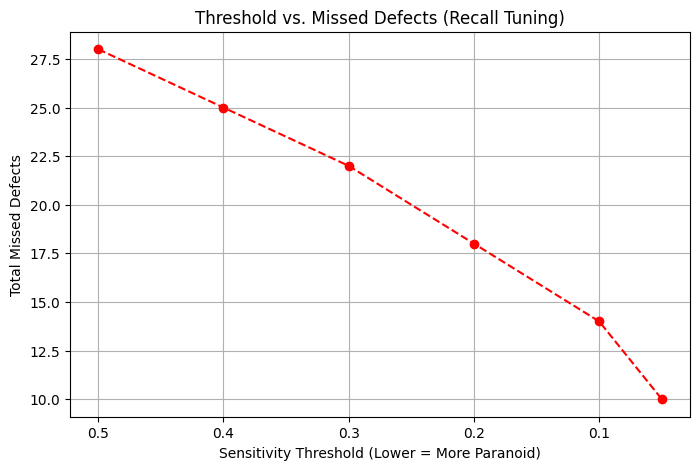

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def run_sensitivity_sweep(model, loader, device):
    thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
    results = []

    for t in thresholds:
        missed = evaluate_with_threshold(model, loader, device, threshold=t)
        results.append({"Threshold": t, "Misses": missed})

    df = pd.DataFrame(results)

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.plot(df['Threshold'], df['Misses'], marker='o', color='red', linestyle='--')
    plt.gca().invert_xaxis() # High threshold to Low threshold
    plt.title("Threshold vs. Missed Defects (Recall Tuning)")
    plt.xlabel("Sensitivity Threshold (Lower = More Paranoid)")
    plt.ylabel("Total Missed Defects")
    plt.grid(True)
    plt.show()

    return df

# Run the sweep
sweep_results = run_sensitivity_sweep(model, val_loader, device)

In [ ]:
import torch
import torch.ao.quantization as quantization
import os

# 1. SAVE THE FP32 MODEL FIRST
# We save the current state of model2 to disk so we can measure it
fp32_filename = "sem_hierarchical_fp32.pth"
torch.save(model2.state_dict(), fp32_filename)

def quantize_hierarchical_model(model, calibration_loader):
    # 2. Preparation: Move to CPU (Required for PyTorch Static Quantization)
    model.eval()
    model.to('cpu')

    # 3. Configuration: 'fbgemm' is standard for x86/ARM server/desktop hardware
    model.qconfig = quantization.get_default_qconfig('fbgemm')

    # 4. Prepare: Insert observers to track activation ranges
    model_prepared = quantization.prepare(model)

    # 5. Calibration: Use clean validation data to set the INT8 scales
    print("Calibrating INT8 scales with validation data...")
    with torch.no_grad():
        for i, (images, _) in enumerate(calibration_loader):
            model_prepared(images)
            if i >= 20: break

    # 6. Convert: Finalize to INT8 by swapping float layers for integer ones
    model_int8 = quantization.convert(model_prepared)
    print("Quantization Successful!")
    return model_int8

# EXECUTE QUANTIZATION
model_int8 = quantize_hierarchical_model(model2, val_loader)

# 7. SAVE THE INT8 MODEL
int8_filename = "sem_hierarchical_int8.pth"
torch.save(model_int8.state_dict(), int8_filename)

# 8. SIZE COMPARISON REPORT
if os.path.exists(fp32_filename) and os.path.exists(int8_filename):
    fp32_size = os.path.getsize(fp32_filename) / (1024 * 1024)
    int8_size = os.path.getsize(int8_filename) / (1024 * 1024)

    print("\n" + "="*40)
    print(f"{'MODEL VERSION':<20} | {'SIZE (MB)':<10}")
    print("-" * 40)
    print(f"{'Original FP32':<20} | {fp32_size:<10.2f}")
    print(f"{'Quantized INT8':<20} | {int8_size:<10.2f}")
    print("-" * 40)
    print(f"Compression Ratio: {fp32_size/int8_size:.2f}x")
    print("="*40)

/tmp/ipython-input-902643351.py:19: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantization.prepare(model)


Calibrating INT8 scales with validation data...


/tmp/ipython-input-902643351.py:29: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = quantization.convert(model_prepared)


Quantization Successful!

MODEL VERSION        | SIZE (MB) 
----------------------------------------
Original FP32        | 5.78      
Quantized INT8       | 1.86      
----------------------------------------
Compression Ratio: 3.11x


In [ ]:
import torch
import torch.onnx
import os

# 1. Save your INT8 State Dict (Internal Reference)
# This keeps your quantized weights safe for local Python use
torch.save(model_int8.state_dict(), "sem_model_v3_int8_ref.pth")

# 2. Re-Initialize Model 2 in FP32 for the eIQ Portal
# The eIQ Neutron SDK performs best when it starts with high-precision weights
def export_fp32_for_eiq(model_fp32, save_path="sem_hierarchical_eiq_final.onnx"):
    model_fp32.eval()
    model_fp32.to('cpu')

    # Dummy input: Grayscale, 224x224
    dummy_input = torch.randn(1, 1, 224, 224)

    print(f"Exporting Golden Reference (FP32) to {save_path}...")
    try:
        torch.onnx.export(
            model_fp32,
            dummy_input,
            save_path,
            export_params=True,
            opset_version=13, # Recommended for NXP eIQ Compatibility
            do_constant_folding=True,
            input_names=['input_sem'],
            output_names=['h1', 'h2', 'h3', 'h4', 'h5']
        )
        print("✅ Export Successful! Upload this file to the eIQ Portal.")
    except Exception as e:
        print(f"❌ Export failed: {e}")

# EXECUTE (Targeting your FP32 model2)
export_fp32_for_eiq(model2)

# Verify local file exists
if os.path.exists("sem_hierarchical_eiq_final.onnx"):
    print(f"Final File Size: {os.path.getsize('sem_hierarchical_eiq_final.onnx')/(1024**2):.2f} MB")

W0208 11:49:45.927000 493 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


Exporting Golden Reference (FP32) to sem_hierarchical_eiq_final.onnx...


W0208 11:49:47.459000 493 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0208 11:49:47.464000 493 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0208 11:49:47.472000 493 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.
W0208 11:49:47.478000 493 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.


[torch.onnx] Obtain model graph for `SEMHierarchicalNetV3_QAT([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SEMHierarchicalNetV3_QAT([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Translate the graph into ONNX... ✅
Applied 70 of general pattern rewrite rules.
✅ Export Successful! Upload this file to the eIQ Portal.
Final File Size: 0.30 MB


In [ ]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score

def refined_train_model2(model, train_loader, val_loader, epochs=10):
    # 1. Setup Head Weights (Focusing 3x more on H1)
    head_weights = {'h1': 3.0, 'h2': 1.0, 'h3': 1.0, 'h4': 0.5, 'h5': 0.5}

    # 2. Re-initialize Optimizer for refinement
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Ensure criterion is accessible (usually nn.CrossEntropyLoss)
    criterion = torch.nn.CrossEntropyLoss()

    print(f"Starting Refinement for Model 2 (Target: H1 Recovery)")
    print(f"Weights: {head_weights}")
    print("-" * 30)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            total_loss = 0
            for i, h in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                mask = labels[:, i] != -1
                if mask.any():
                    # Weighted Loss Application
                    loss_component = criterion(outputs[h][mask], labels[:, i][mask])
                    total_loss += head_weights[h] * loss_component

            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        # --- Real-time H1 Validation ---
        model.eval()
        h1_preds, h1_true = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                out = model(images)
                # Mask for H1 (should be everything in val)
                mask = labels[:, 0] != -1
                preds = torch.argmax(out['h1'][mask], dim=1)
                h1_preds.extend(preds.cpu().numpy())
                h1_true.extend(labels[:, 0][mask].cpu().numpy())

        current_h1_acc = accuracy_score(h1_true, h1_preds)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss/len(train_loader):.4f} | Val H1 Acc: {current_h1_acc:.4f}")

# EXECUTE
refined_train_model2(model2, train_loader, val_loader, epochs=10)

Starting Refinement for Model 2 (Target: H1 Recovery)
Weights: {'h1': 3.0, 'h2': 1.0, 'h3': 1.0, 'h4': 0.5, 'h5': 0.5}
------------------------------
Epoch [1/10] | Loss: 0.3212 | Val H1 Acc: 0.9413
Epoch [2/10] | Loss: 0.2292 | Val H1 Acc: 0.9352
Epoch [3/10] | Loss: 0.2470 | Val H1 Acc: 0.9372
Epoch [4/10] | Loss: 0.2084 | Val H1 Acc: 0.9433
Epoch [5/10] | Loss: 0.2097 | Val H1 Acc: 0.9474
Epoch [6/10] | Loss: 0.2530 | Val H1 Acc: 0.9453
Epoch [7/10] | Loss: 0.2181 | Val H1 Acc: 0.9352
Epoch [8/10] | Loss: 0.1980 | Val H1 Acc: 0.9474
Epoch [9/10] | Loss: 0.2046 | Val H1 Acc: 0.9494
Epoch [10/10] | Loss: 0.1763 | Val H1 Acc: 0.9433


--- Comprehensive Hierarchical Evaluation on cuda ---

H1: Detection (Primary) Report:
              precision    recall  f1-score   support

      Normal     0.8902    1.0000    0.9419       227
      Defect     1.0000    0.8951    0.9447       267

    accuracy                         0.9433       494
   macro avg     0.9451    0.9476    0.9433       494
weighted avg     0.9495    0.9433    0.9434       494


H2: Branching (3-Way) Report:
              precision    recall  f1-score   support

          OB     0.9659    1.0000    0.9827        85
          CC     1.0000    1.0000    1.0000        84
      LER-IE     1.0000    0.9694    0.9845        98

    accuracy                         0.9888       267
   macro avg     0.9886    0.9898    0.9890       267
weighted avg     0.9891    0.9888    0.9888       267


H3: OB Sub-classes Report:
              precision    recall  f1-score   support

        Open     0.9556    1.0000    0.9773        43
      Bridge     1.0000    0.9524    

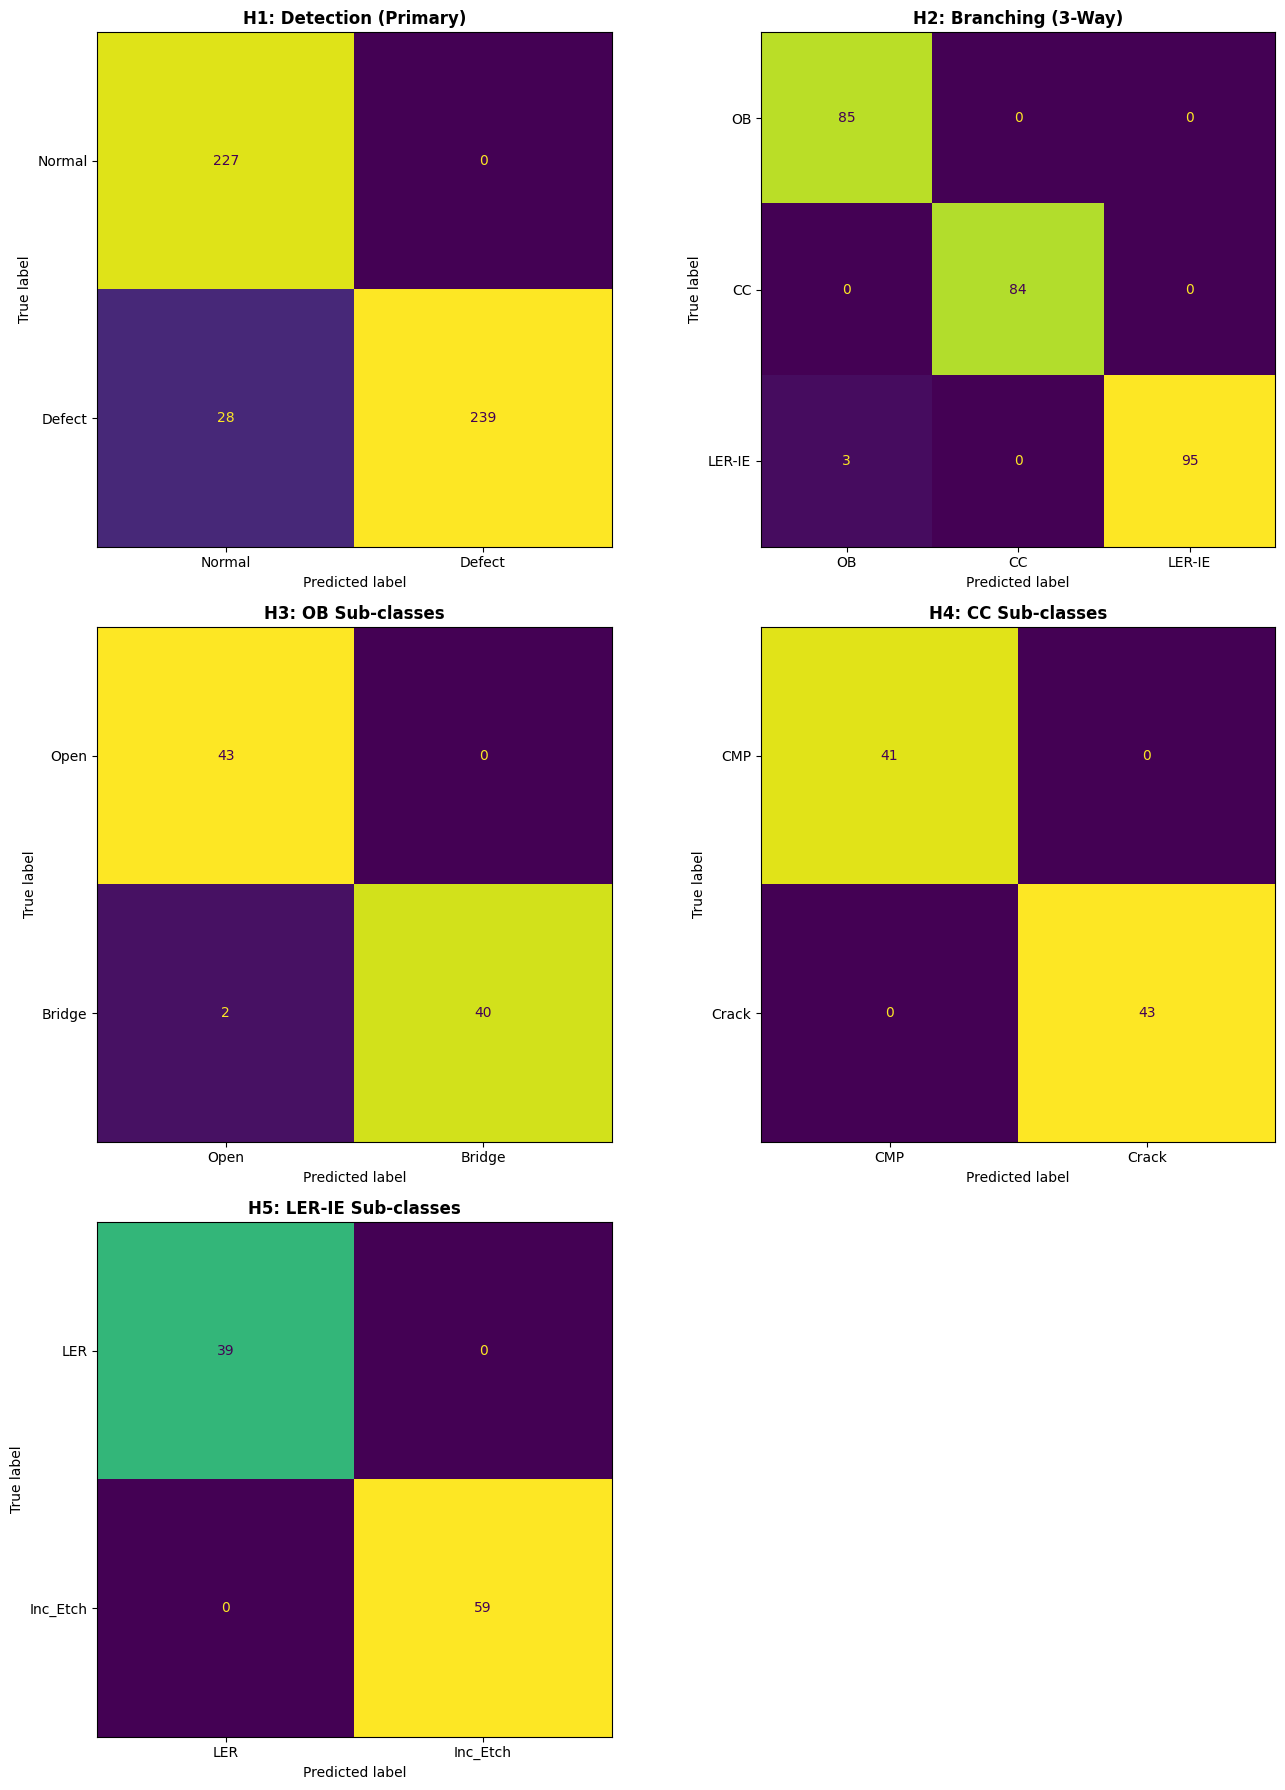

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def evaluate_refined_hierarchical_model(model, loader, device):
    model.eval()

    # Storage for predictions and ground truth per head
    results = {f'h{i+1}': {'preds': [], 'true': []} for i in range(5)}

    # Human-readable labels for the hierarchy
    head_metadata = {
        'h1': {'labels': ['Normal', 'Defect'], 'title': 'H1: Detection (Primary)'},
        'h2': {'labels': ['OB', 'CC', 'LER-IE'], 'title': 'H2: Branching (3-Way)'},
        'h3': {'labels': ['Open', 'Bridge'], 'title': 'H3: OB Sub-classes'},
        'h4': {'labels': ['CMP', 'Crack'], 'title': 'H4: CC Sub-classes'},
        'h5': {'labels': ['LER', 'Inc_Etch'], 'title': 'H5: LER-IE Sub-classes'}
    }

    print(f"--- Comprehensive Hierarchical Evaluation on {device} ---")

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
                # Filter out -1 mask values
                mask = labels[:, i] != -1
                if mask.any():
                    preds = torch.argmax(outputs[h_key][mask], dim=1)
                    results[h_key]['preds'].extend(preds.cpu().numpy())
                    results[h_key]['true'].extend(labels[:, i][mask].cpu().numpy())

    # 1. Output Classification Reports for all heads
    for h_key in ['h1', 'h2', 'h3', 'h4', 'h5']:
        if len(results[h_key]['true']) > 0:
            print(f"\n{head_metadata[h_key]['title']} Report:")
            print(classification_report(
                results[h_key]['true'],
                results[h_key]['preds'],
                target_names=head_metadata[h_key]['labels'],
                digits=4
            ))

    # 2. Generate the Confusion Matrix Grid
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    axes = axes.flatten()

    for i, h_key in enumerate(['h1', 'h2', 'h3', 'h4', 'h5']):
        cm = confusion_matrix(results[h_key]['true'], results[h_key]['preds'])
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=head_metadata[h_key]['labels']
        )
        disp.plot(ax=axes[i], cmap='viridis', colorbar=False, values_format='d')
        axes[i].set_title(head_metadata[h_key]['title'], fontweight='bold')
        axes[i].grid(False)

    # Clean up the layout
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

# EXECUTE
evaluate_refined_hierarchical_model(model2, val_loader, device)

In [ ]:
import torch

def display_missed_defect_filenames(model, val_subset, device, head='h1'):
    model.eval()
    # Create a local loader for the subset to keep indices aligned
    loader = torch.utils.data.DataLoader(val_subset, batch_size=1, shuffle=False)

    # Extract original indices from the subset
    val_indices = val_subset.indices
    missed_files = []

    print(f"--- Searching for {head.upper()} False Negatives (Outlier Candidates) ---")

    with torch.no_grad():
        for i, (image, label) in enumerate(loader):
            image = image.to(device)
            output = model(image)

            # Prediction for Head 1
            pred = torch.argmax(output[head], dim=1).item()
            true_label = label[0, 0].item() # H1 is the first column

            # Identification of False Negative: True=Defect(1), Pred=Normal(0)
            if true_label == 1 and pred == 0:
                # Map back to the original dataset's file list
                original_idx = val_indices[i]
                file_path = full_dataset.image_paths[original_idx]
                missed_files.append(file_path)
                print(f"Missed Defect Found: {os.path.basename(file_path)}")

    print(f"\nTotal Outlier Candidates: {len(missed_files)}")
    return missed_files

# EXECUTE
# Ensure 'full_dataset' and 'val_subset' are defined from your previous steps
outlier_paths = display_missed_defect_filenames(model2, val_subset, device)

--- Searching for H1 False Negatives (Outlier Candidates) ---
Missed Defect Found: test_normal_00010.jpg
Missed Defect Found: test_normal_00053.jpg
Missed Defect Found: WhatsApp Image 2026-02-06 at 7.04.09 PM_90.jpeg
Missed Defect Found: test_normal_00001.jpg
Missed Defect Found: test_normal_00125.jpg
Missed Defect Found: test_normal_00005.jpg
Missed Defect Found: test_normal_00153.jpg
Missed Defect Found: test_normal_00149.jpg
Missed Defect Found: test_normal_00041.jpg
Missed Defect Found: test_normal_00186.jpg
Missed Defect Found: test_normal_00113.jpg
Missed Defect Found: test_normal_00098.jpg
Missed Defect Found: test_normal_00063.jpg
Missed Defect Found: WhatsApp Image 2026-02-06 at 7.04.09 PM.jpeg
Missed Defect Found: test_normal_00118.jpg
Missed Defect Found: WhatsApp Image 2026-02-06 at 7.42.14 PM.jpeg
Missed Defect Found: test_normal_00081.jpg
Missed Defect Found: test_normal_00009.jpg
Missed Defect Found: test_normal_00049.jpg
Missed Defect Found: test_normal_00042.jpg
Missed